# CPH

In [1]:
import pandas as pd

# 치료 유형 확인
df = pd.read_csv('./origin_colon_cancer.csv')
tx_cols = [col for col in df.columns if col.startswith('tx_')]
print(tx_cols)

['tx_00000', 'tx_00100', 'tx_01000', 'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100']


Fold 1: Uno's C-index = 0.768, Integrated Brier Score = 0.150
Fold 2: Uno's C-index = 0.753, Integrated Brier Score = 0.156
Fold 3: Uno's C-index = 0.852, Integrated Brier Score = 0.167
Fold 4: Uno's C-index = 0.757, Integrated Brier Score = 0.145
Fold 5: Uno's C-index = 0.744, Integrated Brier Score = 0.151
Fold 6: Uno's C-index = 0.761, Integrated Brier Score = 0.155
Fold 7: Uno's C-index = 0.744, Integrated Brier Score = 0.159
Fold 8: Uno's C-index = 0.760, Integrated Brier Score = 0.146
Fold 9: Uno's C-index = 0.748, Integrated Brier Score = 0.152
Fold 10: Uno's C-index = 0.776, Integrated Brier Score = 0.158
Fold 11: Uno's C-index = 0.800, Integrated Brier Score = 0.166
Fold 12: Uno's C-index = 0.749, Integrated Brier Score = 0.149
Fold 13: Uno's C-index = 0.756, Integrated Brier Score = 0.155
Fold 14: Uno's C-index = 0.758, Integrated Brier Score = 0.152
Fold 15: Uno's C-index = 0.763, Integrated Brier Score = 0.148
Fold 16: Uno's C-index = 0.757, Integrated Brier Score = 0.147
F

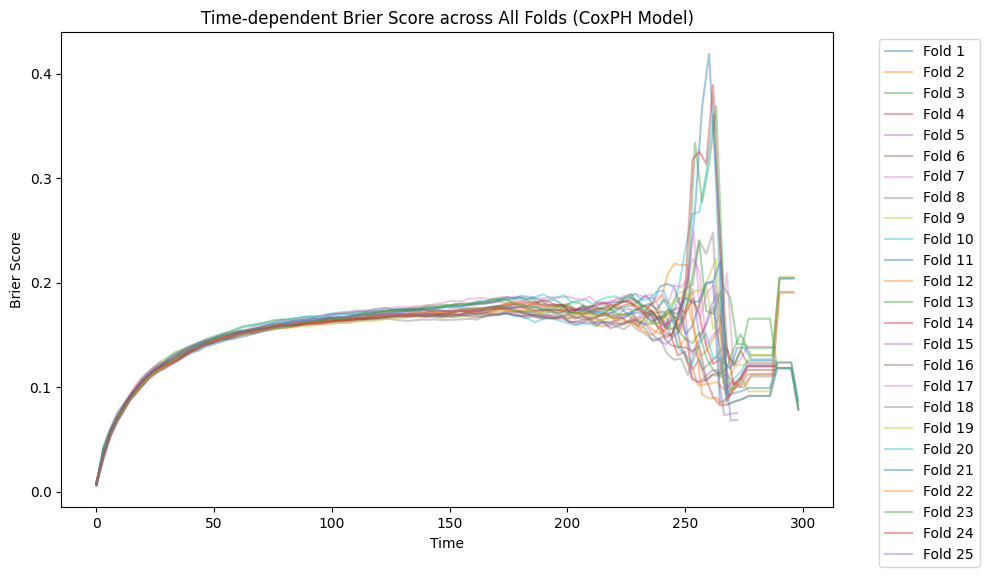

In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RepeatedKFold
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score, brier_score
import matplotlib.pyplot as plt

# 결과 저장 폴더 생성
output_folder = './BS_results'
os.makedirs(output_folder, exist_ok=True)

# --------------------------
# 1. 데이터 로드 및 변수 선택
# --------------------------
df = pd.read_csv("origin_colon_cancer.csv")
df = df[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000', 
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]
# matrix is converged 에러가 나서, tx_00000 컬럼은 제외함. (다중공선성 문제로 추정됨.)

features = ['age_scaled', 'tx_00100', 'tx_01000', 'tx_10000',
             'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
            'Regional', 'Distant', 'sex']

# --------------------------
# 2. Repeated K-Fold 설정
# --------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# 성능 저장용 리스트
cindex_scores = []
ibs_scores = []
fold_times = []
fold_brier = []

fold = 1
# --------------------------
# 3. 각 Fold별 학습 및 평가 루프
# --------------------------
for train_idx, test_idx in rkf.split(df):
    train_df = df.iloc[train_idx].copy()
    test_df  = df.iloc[test_idx].copy()

    X_train = train_df[features]
    X_test  = test_df[features]

    y_train = np.array([(bool(e), t) for e, t in zip(train_df['event_inc'], train_df['stime'])],
                       dtype=[('event', 'bool'), ('time', 'f8')])
    y_test = np.array([(bool(e), t) for e, t in zip(test_df['event_inc'], test_df['stime'])],
                      dtype=[('event', 'bool'), ('time', 'f8')])

    cph_fold = CoxPHFitter()
    cph_fold.fit(train_df, duration_col='stime', event_col='event_inc')

    # 예측 위험 점수 및 C-index 계산
    pred_risk = cph_fold.predict_partial_hazard(test_df).values.ravel()
    fold_cindex = concordance_index_ipcw(y_train, y_test, pred_risk, tau=None)[0]
    cindex_scores.append(fold_cindex)

    # 시간 grid 생성 및 생존함수 예측
    time_grid_fold = np.linspace(0, test_df['stime'].max() - 1e-6, 100)
    surv_funcs = cph_fold.predict_survival_function(test_df, times=time_grid_fold)
    pred_surv = surv_funcs.values.T

    # IBS 및 시간별 Brier Score 계산
    fold_ibs = integrated_brier_score(y_train, y_test, pred_surv, time_grid_fold)
    ibs_scores.append(fold_ibs)

    times_fold, brier_scores = brier_score(y_train, y_test, pred_surv, time_grid_fold)
    fold_times.append(times_fold)
    fold_brier.append(brier_scores)

    print(f"Fold {fold}: Uno's C-index = {fold_cindex:.3f}, Integrated Brier Score = {fold_ibs:.3f}")
    fold += 1

# --------------------------
# 4. 성능 요약 및 Best Fold 저장
# --------------------------
avg_cindex = np.mean(cindex_scores)
std_cindex = np.std(cindex_scores)
avg_ibs = np.mean(ibs_scores)
std_ibs = np.std(ibs_scores)

print(f"\n[RepeatedKFold 5x5 결과]")
print(f"Average Uno's C-index: {avg_cindex:.3f} ± {std_cindex:.3f}")
print(f"Average Integrated Brier Score: {avg_ibs:.3f} ± {std_ibs:.3f}")

# IBS가 가장 낮은 Fold 선택
ibs_array = np.array(ibs_scores)
best_fold_idx = np.argmin(ibs_array)
print(f"Best Fold (lowest IBS): Fold {best_fold_idx + 1}")

# 해당 Fold의 Time grid 및 Brier Score 저장 (모형 비교 시각화용)
best_time_grid = fold_times[best_fold_idx]
best_brier_score_curve = fold_brier[best_fold_idx]

np.save(os.path.join(output_folder, "coxph_bestfold_time_grid.npy"), best_time_grid)
np.save(os.path.join(output_folder, "coxph_bestfold_brier_scores.npy"), best_brier_score_curve)

print("✅ CoxPH 모델의 Best Fold 기준 Time Grid 및 Brier Score 곡선이 저장되었습니다.")

# --------------------------
# 5. 모든 Fold의 Brier Score 곡선 시각화
# --------------------------
plt.figure(figsize=(10, 6))
for i, (t, brier) in enumerate(zip(fold_times, fold_brier), 1):
    plt.plot(t, brier, label=f'Fold {i}', alpha=0.4)
plt.xlabel('Time')
plt.ylabel('Brier Score')
plt.title('Time-dependent Brier Score across All Folds (CoxPH Model)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# RandomSurvivalForest

RSF Fold 1: Uno's C-index = 0.756, IBS = 0.139
RSF Fold 2: Uno's C-index = 0.745, IBS = 0.147
RSF Fold 3: Uno's C-index = 0.848, IBS = 0.153
RSF Fold 4: Uno's C-index = 0.741, IBS = 0.141
RSF Fold 5: Uno's C-index = 0.734, IBS = 0.140
RSF Fold 6: Uno's C-index = 0.747, IBS = 0.149
RSF Fold 7: Uno's C-index = 0.743, IBS = 0.146
RSF Fold 8: Uno's C-index = 0.743, IBS = 0.154
RSF Fold 9: Uno's C-index = 0.745, IBS = 0.144
RSF Fold 10: Uno's C-index = 0.767, IBS = 0.145
RSF Fold 11: Uno's C-index = 0.794, IBS = 0.169
RSF Fold 12: Uno's C-index = 0.737, IBS = 0.144
RSF Fold 13: Uno's C-index = 0.750, IBS = 0.142
RSF Fold 14: Uno's C-index = 0.744, IBS = 0.143
RSF Fold 15: Uno's C-index = 0.746, IBS = 0.141
RSF Fold 16: Uno's C-index = 0.741, IBS = 0.137
RSF Fold 17: Uno's C-index = 0.736, IBS = 0.155
RSF Fold 18: Uno's C-index = 0.759, IBS = 0.143
RSF Fold 19: Uno's C-index = 0.758, IBS = 0.153
RSF Fold 20: Uno's C-index = 0.739, IBS = 0.144
RSF Fold 21: Uno's C-index = 0.749, IBS = 0.143
R

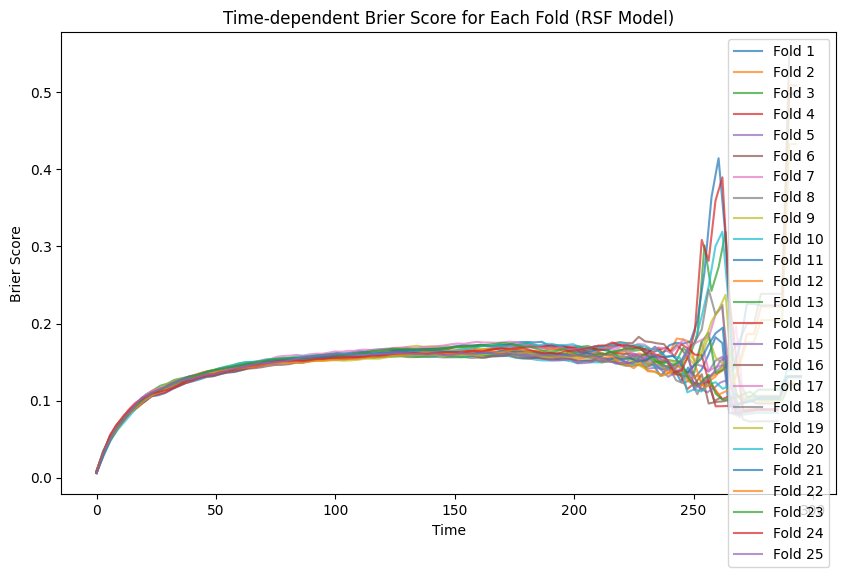

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score, brier_score
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
import os

output_folder = './BS_results'

# --------------------------
# 1. 데이터 로드 및 변수 선택
# --------------------------
df = pd.read_csv("origin_colon_cancer.csv")
df = df[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000', 
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]

features = ['age_scaled', 'tx_00100', 'tx_01000', 'tx_10000',
             'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100','tx_00000',
            'Regional', 'Distant', 'sex']

# 5-Fold CV 설정
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

rsf_cindex_scores = []
rsf_ibs_scores = []
rsf_fold_times = []    # 각 Fold의 time grid 저장
rsf_fold_brier = []    # 각 Fold의 시간별 Brier Score 배열 저장

fold = 1
for train_index, test_index in rkf.split(df):
    # 데이터 분할
    train_df = df.iloc[train_index].copy()
    test_df = df.iloc[test_index].copy()
    
    X_train = train_df[features]
    X_test = test_df[features]
    
    # survival outcome을 위한 structured array 생성 (scikit-survival 형식)
    y_train = np.array([(bool(e), t) for e, t in zip(train_df['event_inc'], train_df['stime'])],
                       dtype=[('event', 'bool'), ('time', 'f8')])
    y_test = np.array([(bool(e), t) for e, t in zip(test_df['event_inc'], test_df['stime'])],
                      dtype=[('event', 'bool'), ('time', 'f8')])
    
    # RSF 모델 적합: 최적의 파라미터를 사용 (예시)
    rsf = RandomSurvivalForest(
        n_estimators=283,
        max_depth=14,
        min_samples_split=8,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rsf.fit(X_train, y_train)
    
    # Test set의 생존 함수 예측 (각 환자마다 함수가 반환됨)
    surv_funcs = rsf.predict_survival_function(X_test)
    # Fold의 test follow-up 범위에 맞는 time grid (최대값 미포함)
    time_grid_fold = np.linspace(0, test_df['stime'].max(), 100, endpoint=False)
    # 각 환자에 대해 time grid에서 생존 확률을 평가하여 배열로 변환
    pred_surv = np.vstack([fn(time_grid_fold) for fn in surv_funcs])
    
    # 위험 점수 계산: 마지막 time point의 생존 확률에 음수 부호 (낮을수록 위험도가 높음)
    risk_scores = -pred_surv[:, -1]
    
    # Uno's C-index 계산 (concordance_index_ipcw 사용; 첫번째 리턴값)
    c_index = concordance_index_ipcw(y_train, y_test, risk_scores, tau=None)[0]
    rsf_cindex_scores.append(c_index)
    
    # Integrated Brier Score 계산
    ibs = integrated_brier_score(y_train, y_test, pred_surv, time_grid_fold)
    rsf_ibs_scores.append(ibs)
    
    # Fold별 time-dependent Brier Score 계산 (반환값: (times, scores))
    times_fold, brier_scores = brier_score(y_train, y_test, pred_surv, time_grid_fold)
    rsf_fold_times.append(times_fold)
    rsf_fold_brier.append(brier_scores)
    
    print(f"RSF Fold {fold}: Uno's C-index = {c_index:.3f}, IBS = {ibs:.3f}")
    fold += 1

# 평균 및 표준편차 계산 및 출력
avg_cindex = np.mean(rsf_cindex_scores)
std_cindex = np.std(rsf_cindex_scores)
avg_ibs = np.mean(rsf_ibs_scores)
std_ibs = np.std(rsf_ibs_scores)

print(f"\nRSF Average Uno's C-index: {avg_cindex:.3f} ± {std_cindex:.3f}")
print(f"RSF Average IBS: {avg_ibs:.3f} ± {std_ibs:.3f}")

# -------------------------------
# 전체 Fold 중 IBS가 가장 낮은 Fold 선택 (최적 Fold)
ibs_array = np.array(rsf_ibs_scores)
print(ibs_array)
best_fold_idx = np.argmin(ibs_array)  # (0-based index))
print(f"Best Fold (lowest IBS): Fold {best_fold_idx + 1}")

# 해당 Fold의 time grid와 Brier Score 배열 추출
best_fold_time = rsf_fold_times[best_fold_idx]
best_fold_brier = rsf_fold_brier[best_fold_idx]

# -------------------------------
# 전체 Fold의 Time-dependent Brier Score Plot (CoxPH 모델)
plt.figure(figsize=(10, 6))
for i, (t, brier) in enumerate(zip(rsf_fold_times, rsf_fold_brier), 1):
    plt.plot(t, brier, label=f'Fold {i}', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Brier Score')
plt.title('Time-dependent Brier Score for Each Fold (RSF Model)')
plt.legend()
plt.show()

# XAI

## 1. Permutation Importance

In [1]:
import numpy as np
np.random.seed(42)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score, brier_score
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
import os

output_folder = './BS_results'

# --------------------------
# 1. 데이터 로드 및 변수 선택
# --------------------------
df = pd.read_csv("origin_colon_cancer.csv")
df = df[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000', 
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100','tx_00000',
         'Regional', 'Distant', 'sex',]]
# matrix is converged 에러가 나서, tx_00000 컬럼은 제외함. (다중공선성 문제로 추정됨.)

features = ['age_scaled', 'tx_00100', 'tx_01000', 'tx_10000',
             'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100','tx_00000',
            'Regional', 'Distant', 'sex']

# 5-Fold CV 설정
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

rsf_cindex_scores = []
rsf_ibs_scores = []
rsf_fold_times = []    # 각 Fold의 time grid 저장
rsf_fold_brier = []    # 각 Fold의 시간별 Brier Score 배열 저장

fold = 1
for train_index, test_index in rkf.split(df):
    # 데이터 분할
    train_df = df.iloc[train_index].copy()
    test_df = df.iloc[test_index].copy()
    
    X_train = train_df[features]
    X_test = test_df[features]
    
    # survival outcome을 위한 structured array 생성 (scikit-survival 형식)
    y_train = np.array([(bool(e), t) for e, t in zip(train_df['event_inc'], train_df['stime'])],
                       dtype=[('event', 'bool'), ('time', 'f8')])
    y_test = np.array([(bool(e), t) for e, t in zip(test_df['event_inc'], test_df['stime'])],
                      dtype=[('event', 'bool'), ('time', 'f8')])
    
    # RSF 모델 적합: 최적의 파라미터를 사용 (예시)
    rsf = RandomSurvivalForest(
        n_estimators=283,
        max_depth=14,
        min_samples_split=8,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rsf.fit(X_train, y_train)
    
    # Test set의 생존 함수 예측 (각 환자마다 함수가 반환됨)
    surv_funcs = rsf.predict_survival_function(X_test)
    # Fold의 test follow-up 범위에 맞는 time grid (최대값 미포함)
    time_grid_fold = np.linspace(0, test_df['stime'].max(), 100, endpoint=False)
    # 각 환자에 대해 time grid에서 생존 확률을 평가하여 배열로 변환
    pred_surv = np.vstack([fn(time_grid_fold) for fn in surv_funcs])
    
    # 위험 점수 계산: 마지막 time point의 생존 확률에 음수 부호 (낮을수록 위험도가 높음)
    risk_scores = -pred_surv[:, -1]
    
    # Uno's C-index 계산 (concordance_index_ipcw 사용; 첫번째 리턴값)
    c_index = concordance_index_ipcw(y_train, y_test, risk_scores, tau=None)[0]
    rsf_cindex_scores.append(c_index)
    
    # Integrated Brier Score 계산
    ibs = integrated_brier_score(y_train, y_test, pred_surv, time_grid_fold)
    rsf_ibs_scores.append(ibs)
    
    # Fold별 time-dependent Brier Score 계산 (반환값: (times, scores))
    times_fold, brier_scores = brier_score(y_train, y_test, pred_surv, time_grid_fold)
    rsf_fold_times.append(times_fold)
    rsf_fold_brier.append(brier_scores)
    
    print(f"RSF Fold {fold}: Uno's C-index = {c_index:.3f}, IBS = {ibs:.3f}")
    fold += 1

# 평균 및 표준편차 계산 및 출력
avg_cindex = np.mean(rsf_cindex_scores)
std_cindex = np.std(rsf_cindex_scores)
avg_ibs = np.mean(rsf_ibs_scores)
std_ibs = np.std(rsf_ibs_scores)

print(f"\nRSF Average Uno's C-index: {avg_cindex:.3f} ± {std_cindex:.3f}")
print(f"RSF Average IBS: {avg_ibs:.3f} ± {std_ibs:.3f}")

# -------------------------------
# 전체 Fold 중 IBS가 가장 낮은 Fold 선택 (최적 Fold)
ibs_array = np.array(rsf_ibs_scores)
print(ibs_array)

best_fold_idx = np.argmin(ibs_array)  # (0-based index))
print(f"Best Fold (lowest IBS): Fold {best_fold_idx + 1}")



RSF Fold 1: Uno's C-index = 0.744, IBS = 0.152
RSF Fold 2: Uno's C-index = 0.713, IBS = 0.154
RSF Fold 3: Uno's C-index = 0.732, IBS = 0.149
RSF Fold 4: Uno's C-index = 0.740, IBS = 0.145
RSF Fold 5: Uno's C-index = 0.743, IBS = 0.145
RSF Fold 6: Uno's C-index = 0.746, IBS = 0.153
RSF Fold 7: Uno's C-index = 0.727, IBS = 0.148
RSF Fold 8: Uno's C-index = 0.733, IBS = 0.162
RSF Fold 9: Uno's C-index = 0.742, IBS = 0.145
RSF Fold 10: Uno's C-index = 0.729, IBS = 0.147
RSF Fold 11: Uno's C-index = 0.745, IBS = 0.146
RSF Fold 12: Uno's C-index = 0.723, IBS = 0.150
RSF Fold 13: Uno's C-index = 0.739, IBS = 0.167
RSF Fold 14: Uno's C-index = 0.742, IBS = 0.141
RSF Fold 15: Uno's C-index = 0.739, IBS = 0.149
RSF Fold 16: Uno's C-index = 0.736, IBS = 0.146
RSF Fold 17: Uno's C-index = 0.753, IBS = 0.151
RSF Fold 18: Uno's C-index = 0.726, IBS = 0.143
RSF Fold 19: Uno's C-index = 0.741, IBS = 0.165
RSF Fold 20: Uno's C-index = 0.726, IBS = 0.148
RSF Fold 21: Uno's C-index = 0.733, IBS = 0.154
R

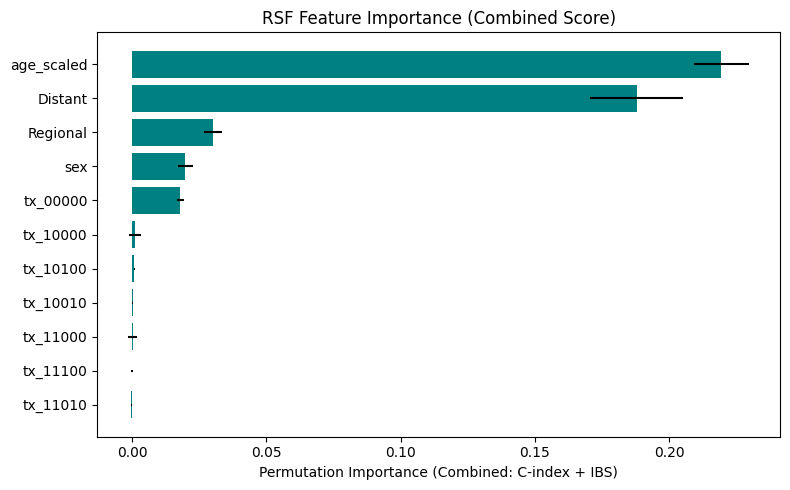

In [3]:
from sklearn.inspection import permutation_importance
from sklearn.utils.validation import check_is_fitted
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_ipcw
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

def rsf_combined_score(estimator, X, y):
    check_is_fitted(estimator)

    # 생존 곡선 예측
    surv_funcs = estimator.predict_survival_function(X)
    time_grid = np.linspace(0, np.max(y["time"])- 1e-5, 100)
    surv_preds = np.vstack([fn(time_grid) for fn in surv_funcs])
    risk_scores = -surv_preds[:, -1]

    # 두 개 지표 평가
    uno_c = concordance_index_ipcw(y_train_best, y, risk_scores)[0]
    ibs = integrated_brier_score(y_train_best, y, surv_preds, time_grid)

    # 조합 점수 반환 (높을수록 좋게 만들기 위해 음수 처리 X)
    # → permutation_importance는 높은 점수가 좋은 것으로 간주하므로 조합 후 '음수' 사용
    return -(ibs - uno_c)  # 혹은 다른 방식도 가능

# best fold의 데이터를 다시 세팅
train_df_best = df.iloc[list(rkf.split(df))[best_fold_idx][0]].copy()
test_df_best  = df.iloc[list(rkf.split(df))[best_fold_idx][1]].copy()

X_train_best = train_df_best[features]
X_test_best = test_df_best[features]

y_train_best = np.array([(bool(e), t) for e, t in zip(train_df_best['event_inc'], train_df_best['stime'])],
                        dtype=[('event', 'bool'), ('time', 'f8')])
y_test_best = np.array([(bool(e), t) for e, t in zip(test_df_best['event_inc'], test_df_best['stime'])],
                       dtype=[('event', 'bool'), ('time', 'f8')])

# RSF 모델 재학습 (best fold용)
rsf_best = RandomSurvivalForest(
    n_estimators=283,
    max_depth=14,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rsf_best.fit(X_train_best, y_train_best)

# Permutation importance 계산
perm_result = permutation_importance(
    estimator=rsf_best,
    X=X_test_best,
    y=y_test_best,
    scoring=rsf_combined_score,
    n_repeats=10,
    random_state=42
)

perm_df = pd.DataFrame({
    "feature": features,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
}).sort_values(by="importance_mean", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(perm_df['feature'], perm_df['importance_mean'], xerr=perm_df['importance_std'], color='teal')
plt.xlabel("Permutation Importance (Combined: C-index + IBS)")
plt.title("RSF Feature Importance (Combined Score)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2. Kernel SHAP

/Users/hyeongdohun/Documents/surv/surv_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hyeongdohun/Documents/surv/surv_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
  0%|          | 0/50 [00:00<?, ?it/s]/Users/hyeongdohun/Documents/surv/surv_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/Users/hyeongdohun/Documents/surv/surv_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
 

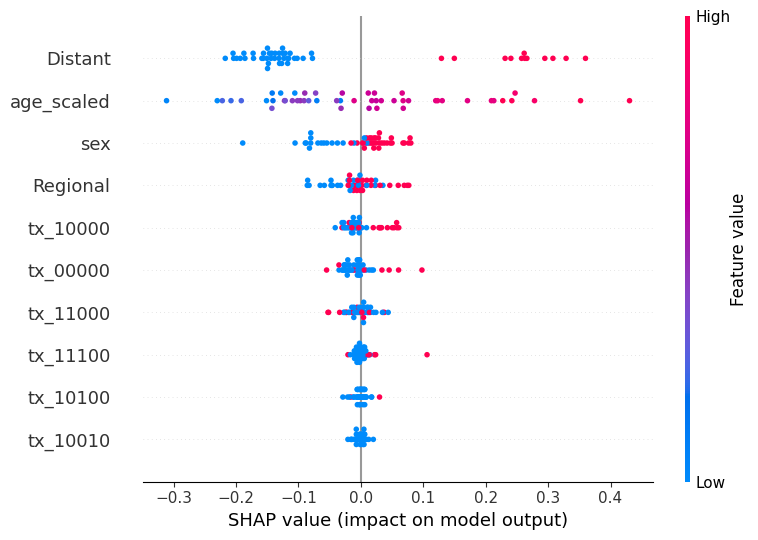

In [4]:
import shap

# 예측 함수 정의: 생존 확률 → 위험 점수로 변환
def predict_risk(X):
    surv_funcs = rsf_best.predict_survival_function(X)
    time_grid = np.linspace(0, np.max(y_test_best["time"])-1e-5, 100, endpoint=False)
    surv_preds = np.vstack([fn(time_grid) for fn in surv_funcs])
    return -surv_preds[:, -1]  # 위험 점수로 반환

# 배경 데이터: 샘플 수 제한 (느리므로 일부 샘플만 사용)
X_background = X_train_best[:100].values if isinstance(X_train_best, pd.DataFrame) else X_train_best[:100]
X_sample = X_test_best[:50].values if isinstance(X_test_best, pd.DataFrame) else X_test_best[:50]

# KernelExplainer 생성
explainer = shap.KernelExplainer(predict_risk, X_background)

# SHAP 값 계산
shap_values = explainer.shap_values(X_sample, nsamples=100)  # nsamples를 줄이면 속도 ↑, 정밀도 ↓

# 요약 플롯
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=features,
    plot_type="dot",
    max_display=10
)